In [219]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.special import expit

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

In [220]:
df = pandas.read_csv(
    "https://docs.google.com/spreadsheets/d/1AZfxs2caMVdYPsiqiZJmX3P-CTq5Yewi3CAccvT7acw/export?format=csv",
    parse_dates=["end_date"])
df = df[df["pollster"].notnull()].copy()
del df["url"]

df = df.melt(
    id_vars=["pollster", "end_date", "population", "mode", "sample_size", "moe", "kind", "partisan", "Weight"],
    var_name="candidate", value_name="pct")
# df = df[df["pct"].notnull()].copy()

In [221]:
df

,pollster,end_date,population,mode,sample_size,moe,kind,partisan,Weight,candidate,pct
0,Fairleigh Dickinson,2023-03-06,vap,phone/text-to-web,808.0,4.60,favourability,0.0,0.75,Baraka,17.0
1,GQR,2024-03-12,lv,voterfile,603.0,4.00,favourability,1.0,0.50,Baraka,17.0
2,GQR,2024-04-12,lv,voterfile,603.0,4.00,horse,1.0,0.50,Baraka,21.0
3,Renaissance Campaign Strategies,2024-07-14,lv,unknown,902.0,3.46,horse,1.0,0.50,Baraka,12.0
4,Rutgers-Eagleton,2024-10-22,rv,panel,929.0,4.20,favourability,0.0,0.75,Baraka,16.0
...,...,...,...,...,...,...,...,...,...,...,...
65,Upswing Research & Strategy,2024-11-27,lv,unknown,803.0,3.46,horse,1.0,0.50,Undecided,29.0
66,Upswing Research & Strategy,2024-11-27,lv,unknown,803.0,3.46,favourability,1.0,0.50,Undecided,12.0
67,Emerson College,2025-01-21,rv,phone/text-to-web/panel,437.0,4.60,favourability,0.0,0.75,Undecided,56.0
68,Public Policy Polling,2025-01-23,lv,text-to-web,615.0,4.00,favourability,1.0,0.50,Undecided,28.0


In [222]:
df["pct_lower"] = df["pct"] - df["moe"]
df["pct_upper"] = df["pct"] + df["moe"]

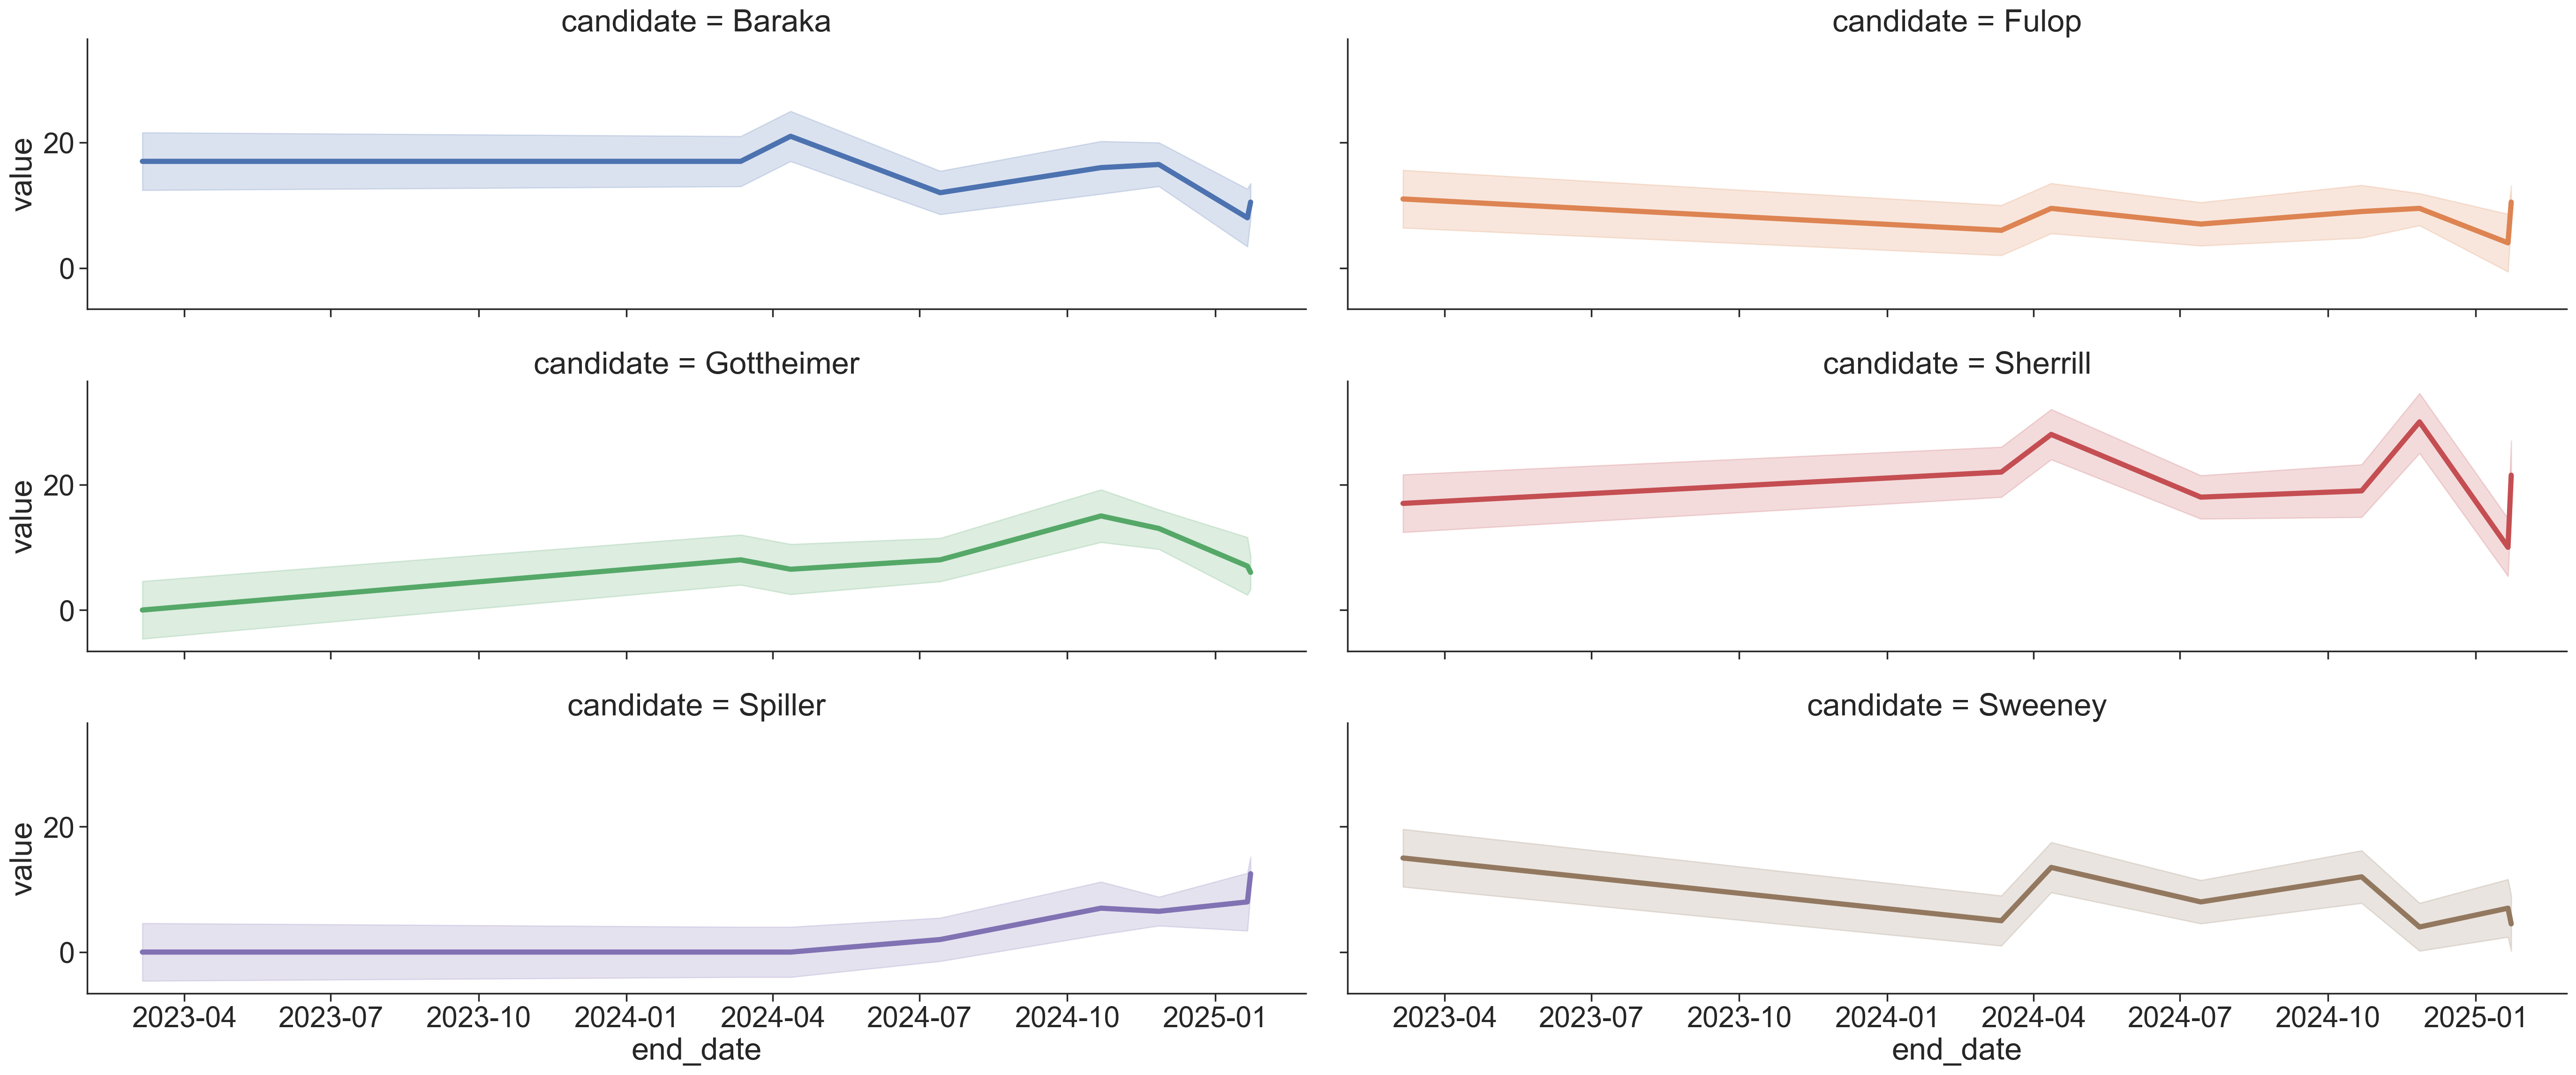

In [223]:
for_plot = df[["end_date", "candidate", "pct", "pct_lower", "pct_upper"]].copy()
for_plot = for_plot.melt(id_vars=["end_date", "candidate"])

ax = sns.relplot(data=for_plot[for_plot["candidate"] != "Undecided"], x="end_date", y="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="line", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

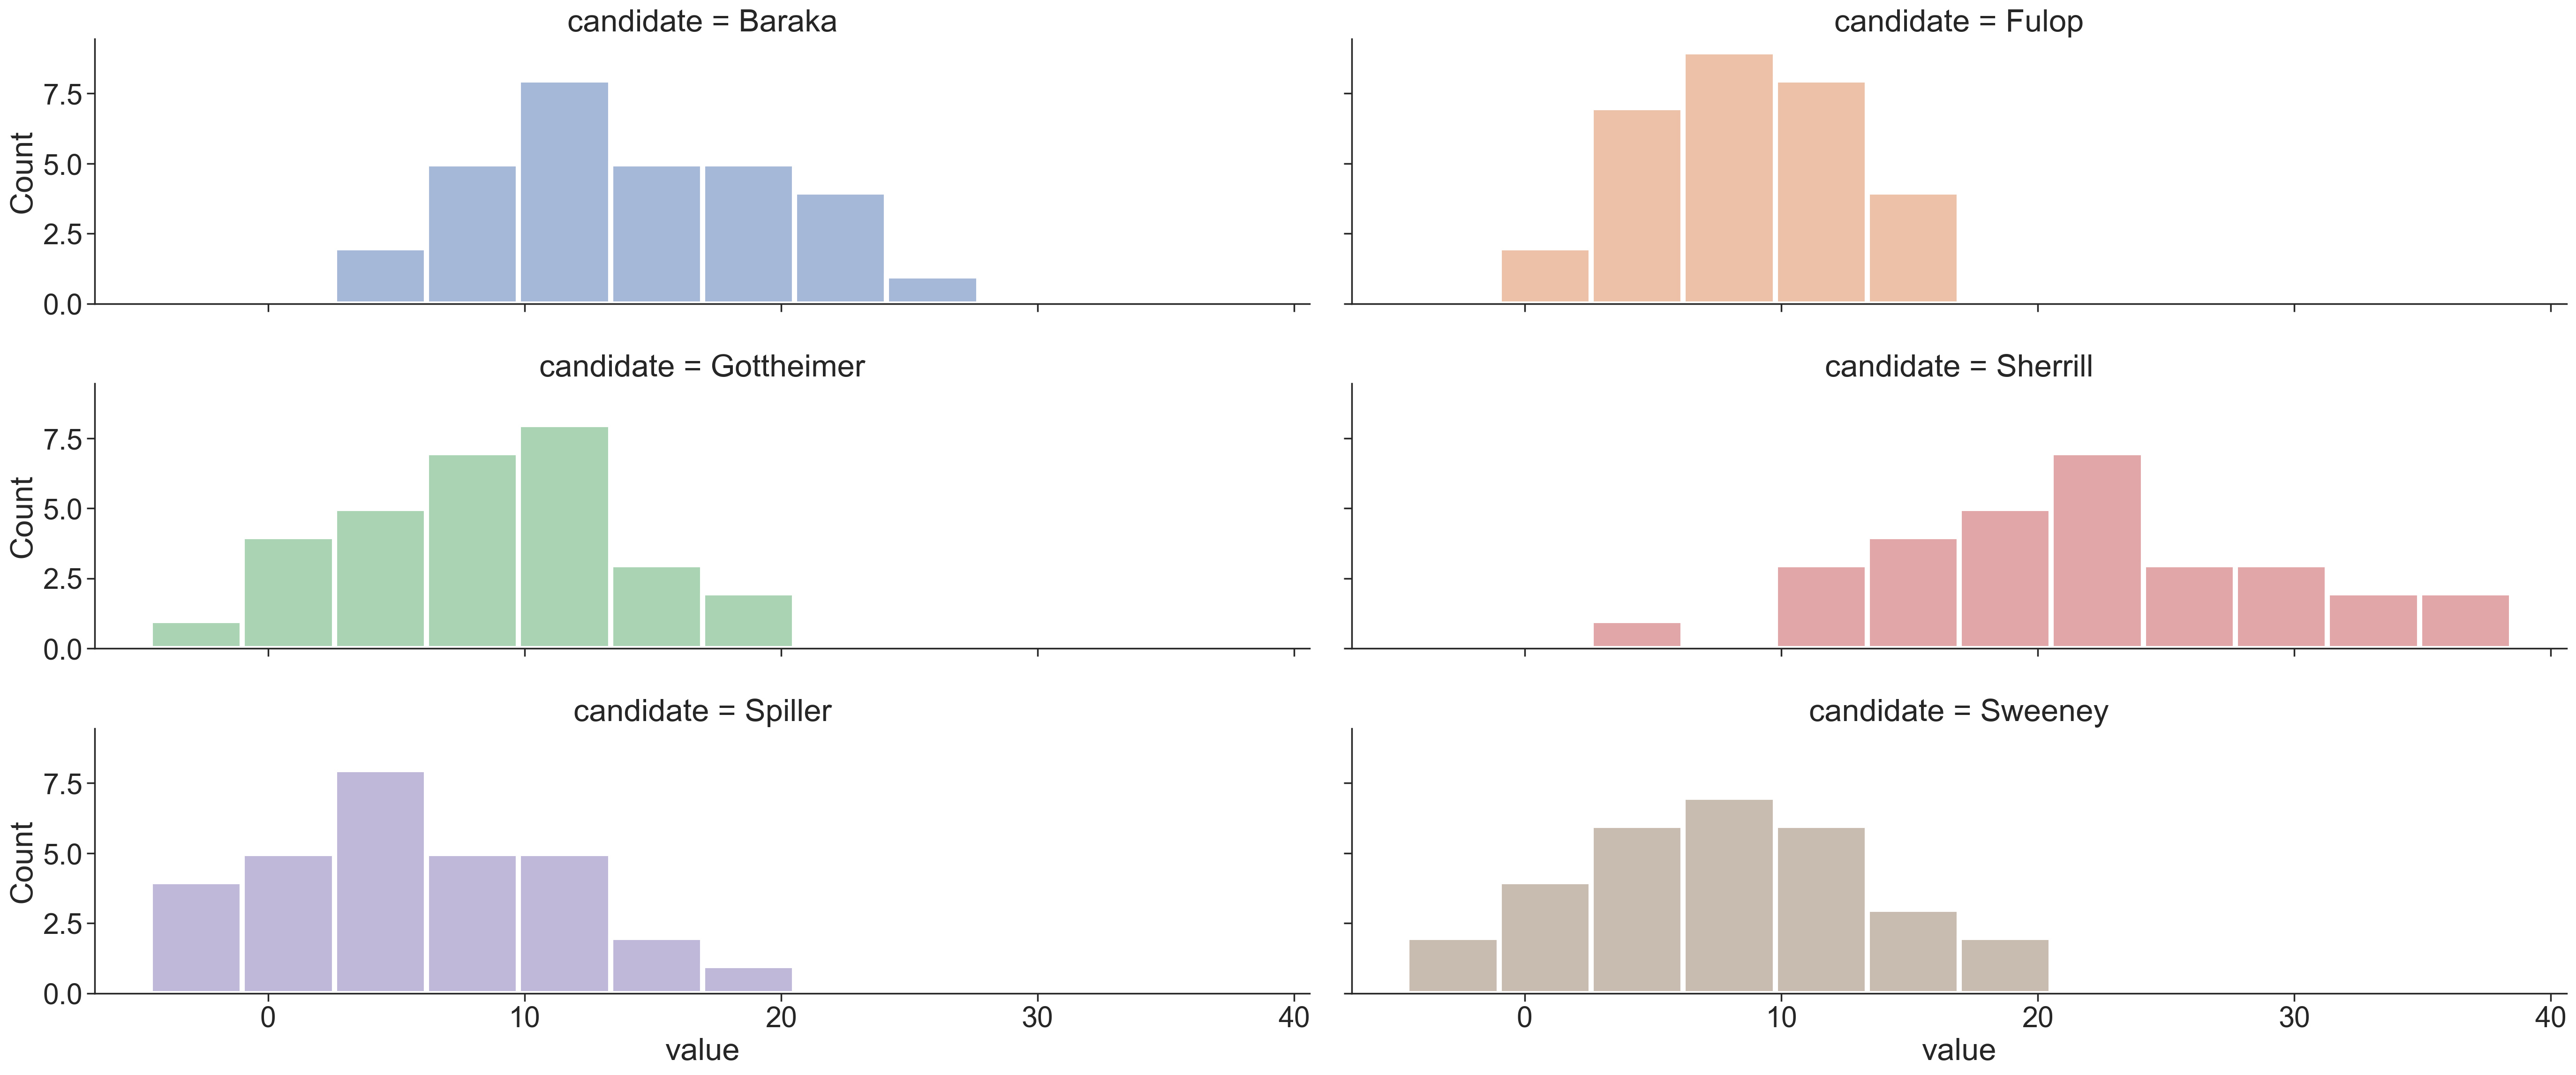

In [224]:
ax = sns.displot(data=for_plot[for_plot["candidate"] != "Undecided"], x="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="hist", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

In [225]:
df["num_for"] = ((df["pct"] / 100) * df["sample_size"]).round(0)
df["num_for_lower"] = ((df["pct_lower"] / 100) * df["sample_size"]).round(0)
df["num_for_upper"] = ((df["pct_upper"] / 100) * df["sample_size"]).round(0)

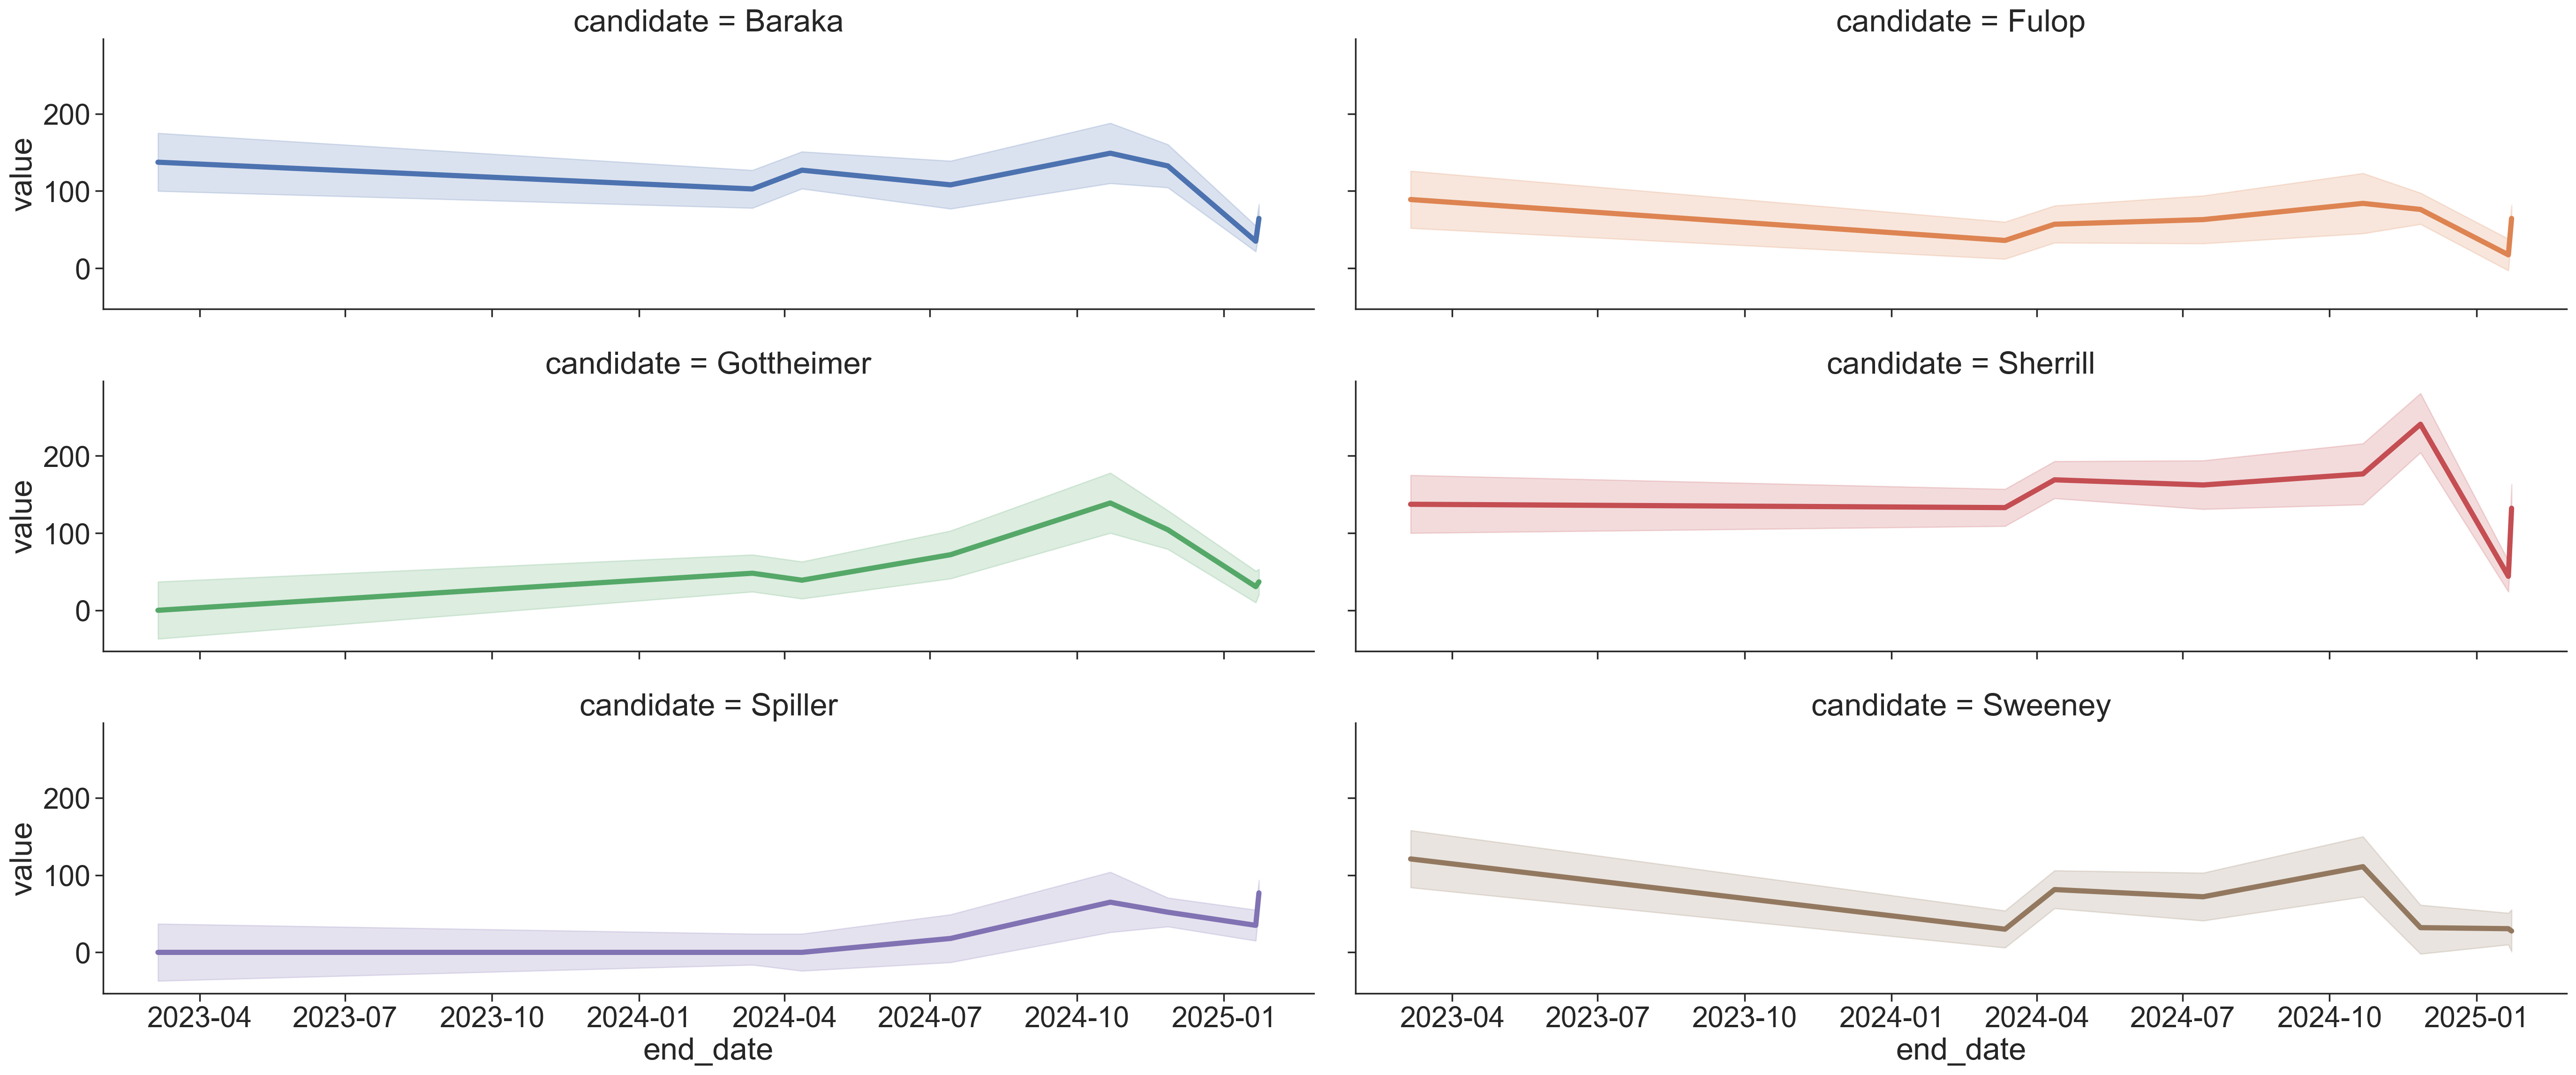

In [226]:
for_plot = df[["end_date", "candidate", "num_for", "num_for_lower", "num_for_upper"]].copy()
for_plot = for_plot.melt(id_vars=["end_date", "candidate"])

ax = sns.relplot(data=for_plot[for_plot["candidate"] != "Undecided"], x="end_date", y="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="line", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

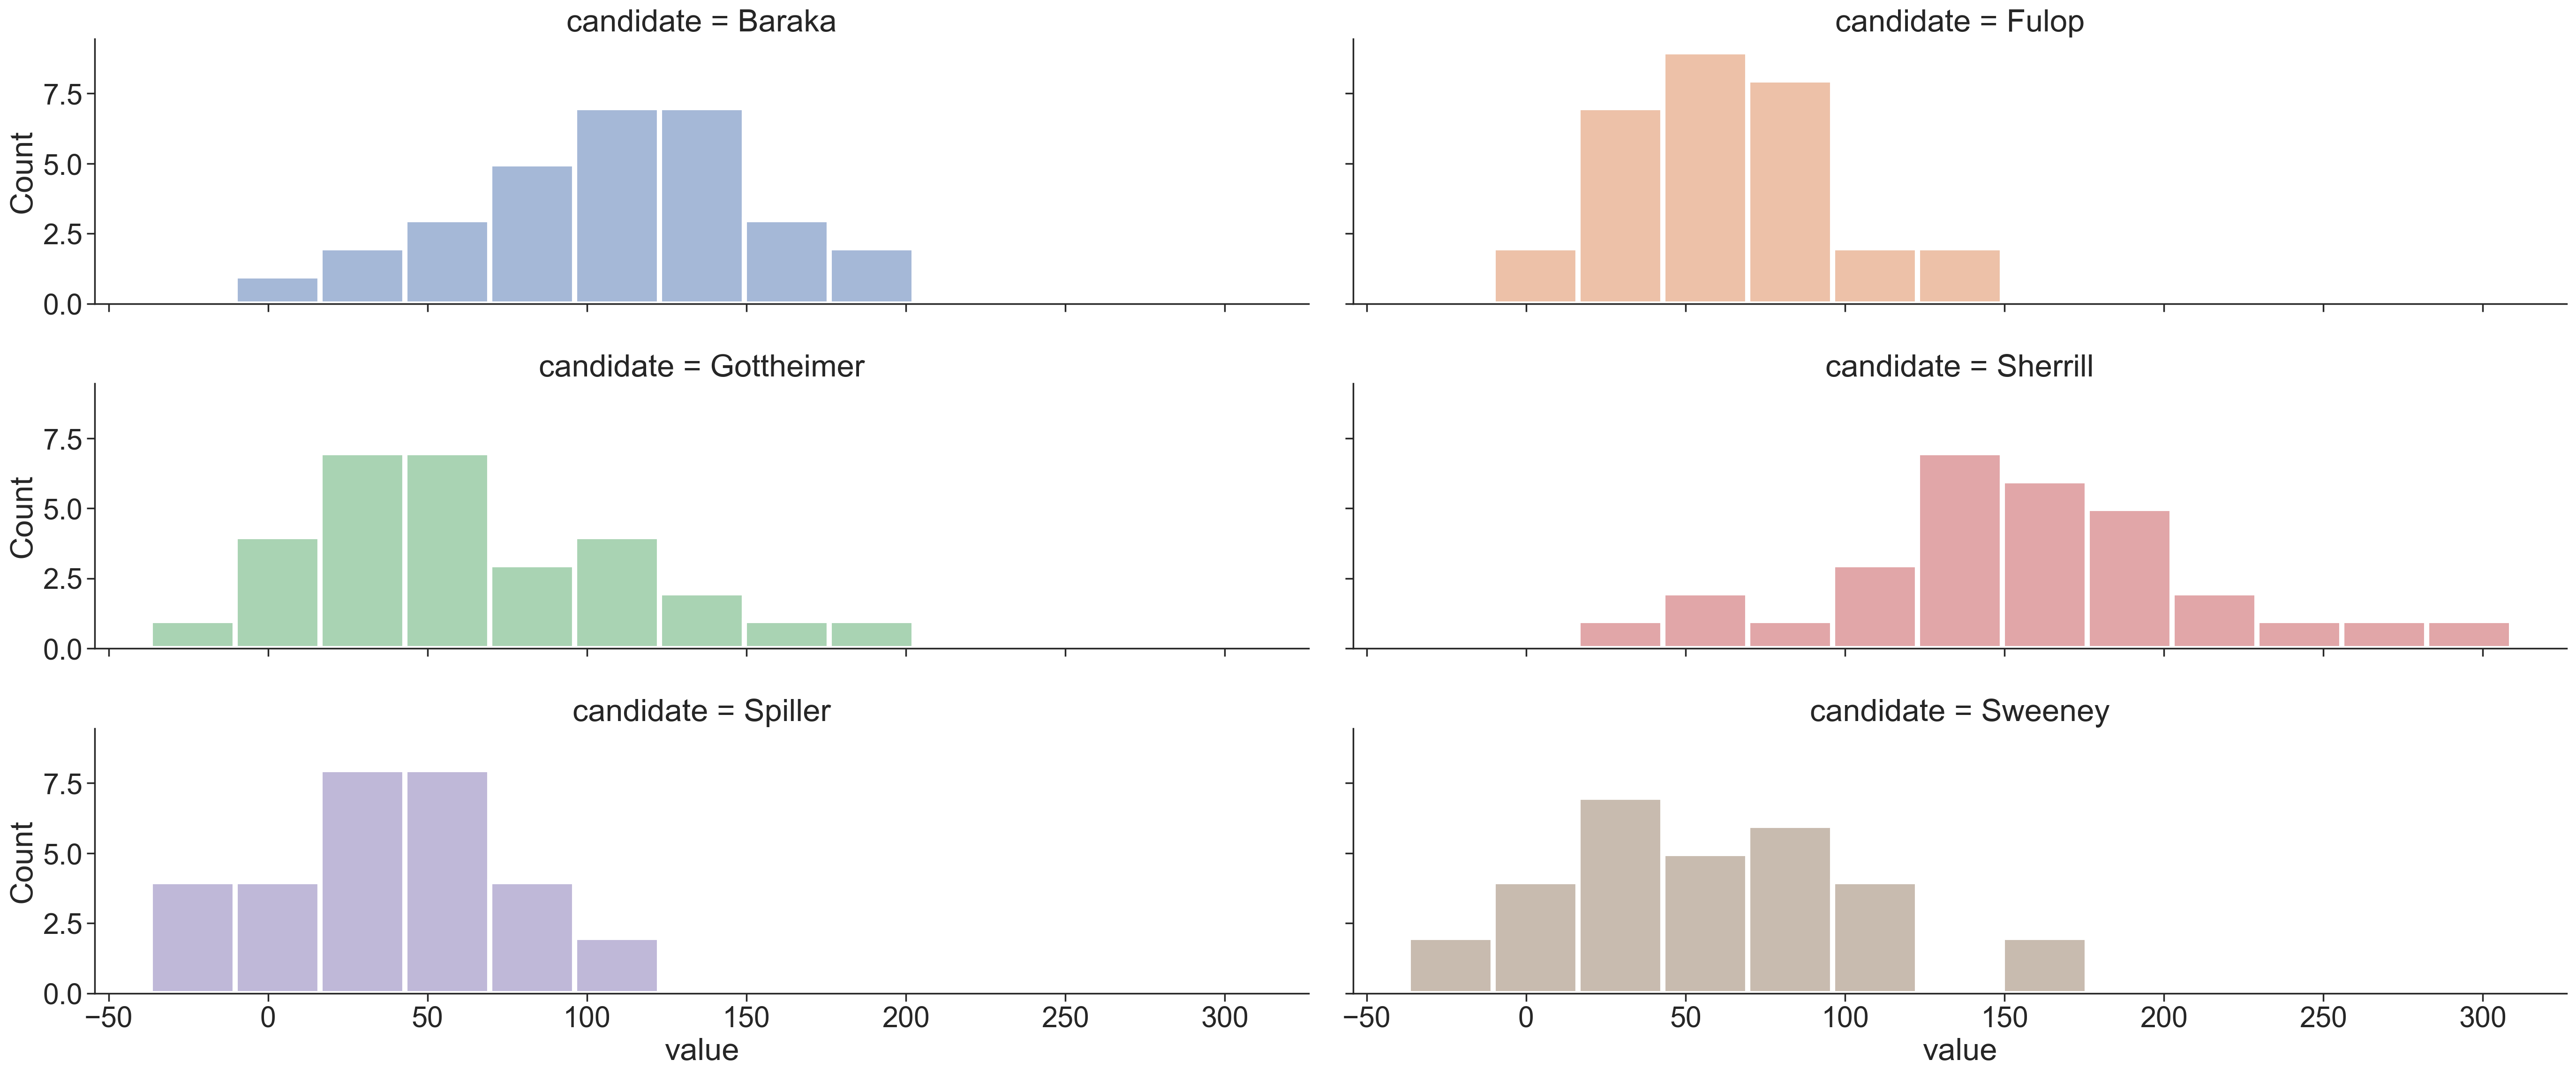

In [227]:
ax = sns.displot(data=for_plot[for_plot["candidate"] != "Undecided"], x="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="hist", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

---

In [1]:
# based on https://alexandorra.github.io/pollsposition_blog/popularity/macron/hidden%20markov%20models/polls/2021/05/16/hmm-popularity.html

In [228]:
cand_id, candidates = df["candidate"].factorize(sort=False)

In [229]:
kind_by_partisan_id, kinds_by_partisan = df.set_index(["kind", "partisan"]).index.factorize(sort=True)
kinds_by_partisan = [x[0] + " partisan" if x[1] == 1 else x[0] for x in kinds_by_partisan]

In [230]:
# month_id = pandas.Categorical(df["end_date"].dt.to_period("M")).codes
# months = sorted(set(month_id))
# df["month_id"] = month_id

In [231]:
coords = {
    "observation" : df.index,
    "candidate" : candidates,
    "kind_by_partisan" : kinds_by_partisan
    # "month" : months
}

In [232]:
with pm.Model(coords=coords) as model:
    kind_effect = pm.Normal("kind_effect", 0, 0.15, dims="kind_by_partisan")
    shrinkage_pop = pm.HalfNormal("shrinkage_pop", 0.2)
    cand_effect = pm.Normal("candidate_effect", mu=0, sigma=shrinkage_pop, dims="candidate")

    popularity = pm.math.invlogit(kind_effect[kind_by_partisan_id] + cand_effect[cand_id])

    y_hat = pm.Binomial(
        "y_hat",
        p=popularity,
        n=df["sample_size"],
        observed=df["num_for"],
        dims="observation",
    )

In [233]:
with model:
    idata = pm.sample(extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kind_effect, shrinkage_pop, candidate_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


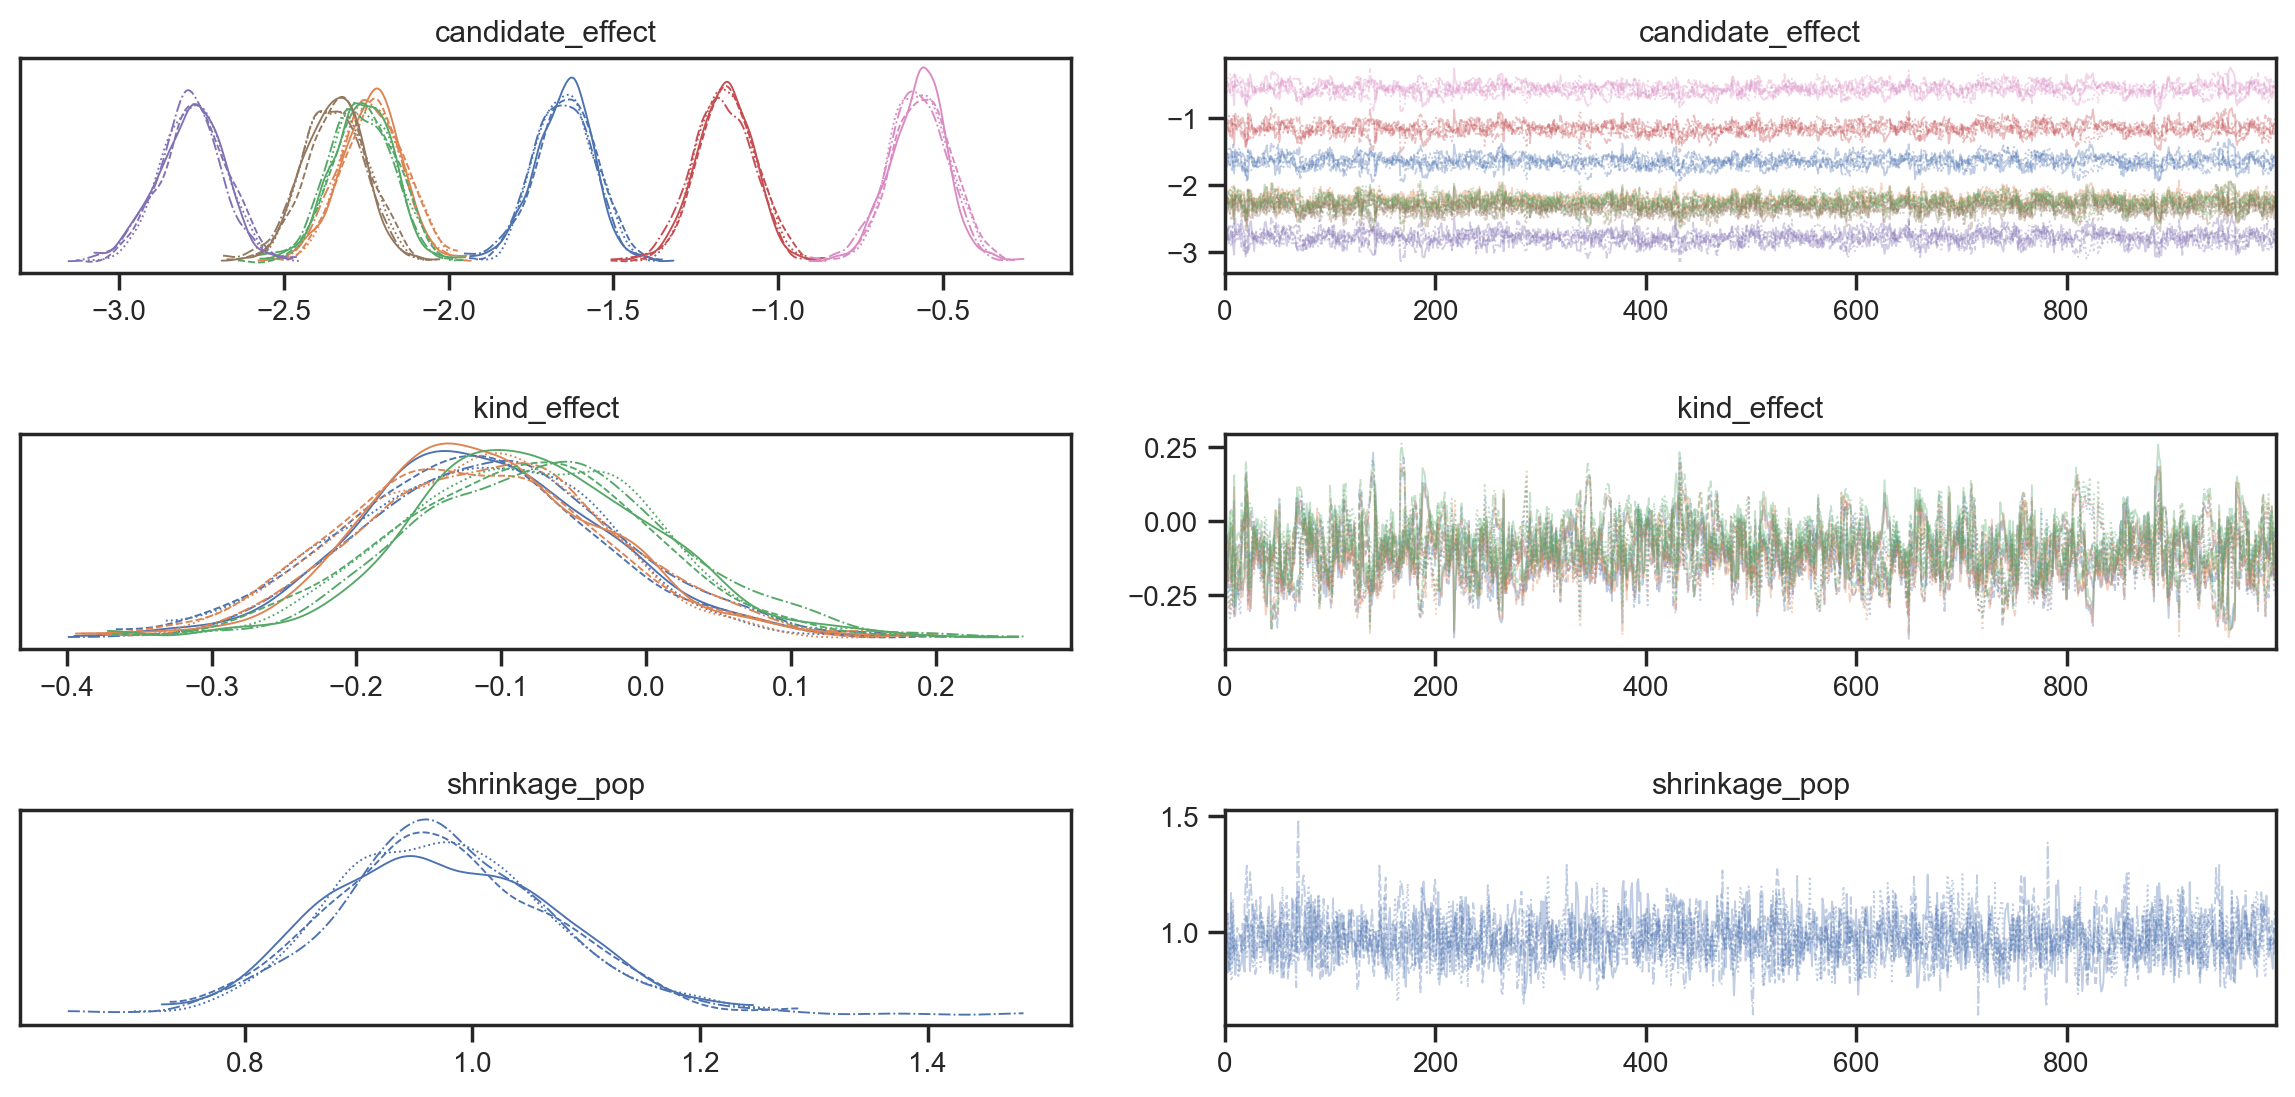

In [234]:
az.plot_trace(idata);
plt.tight_layout()

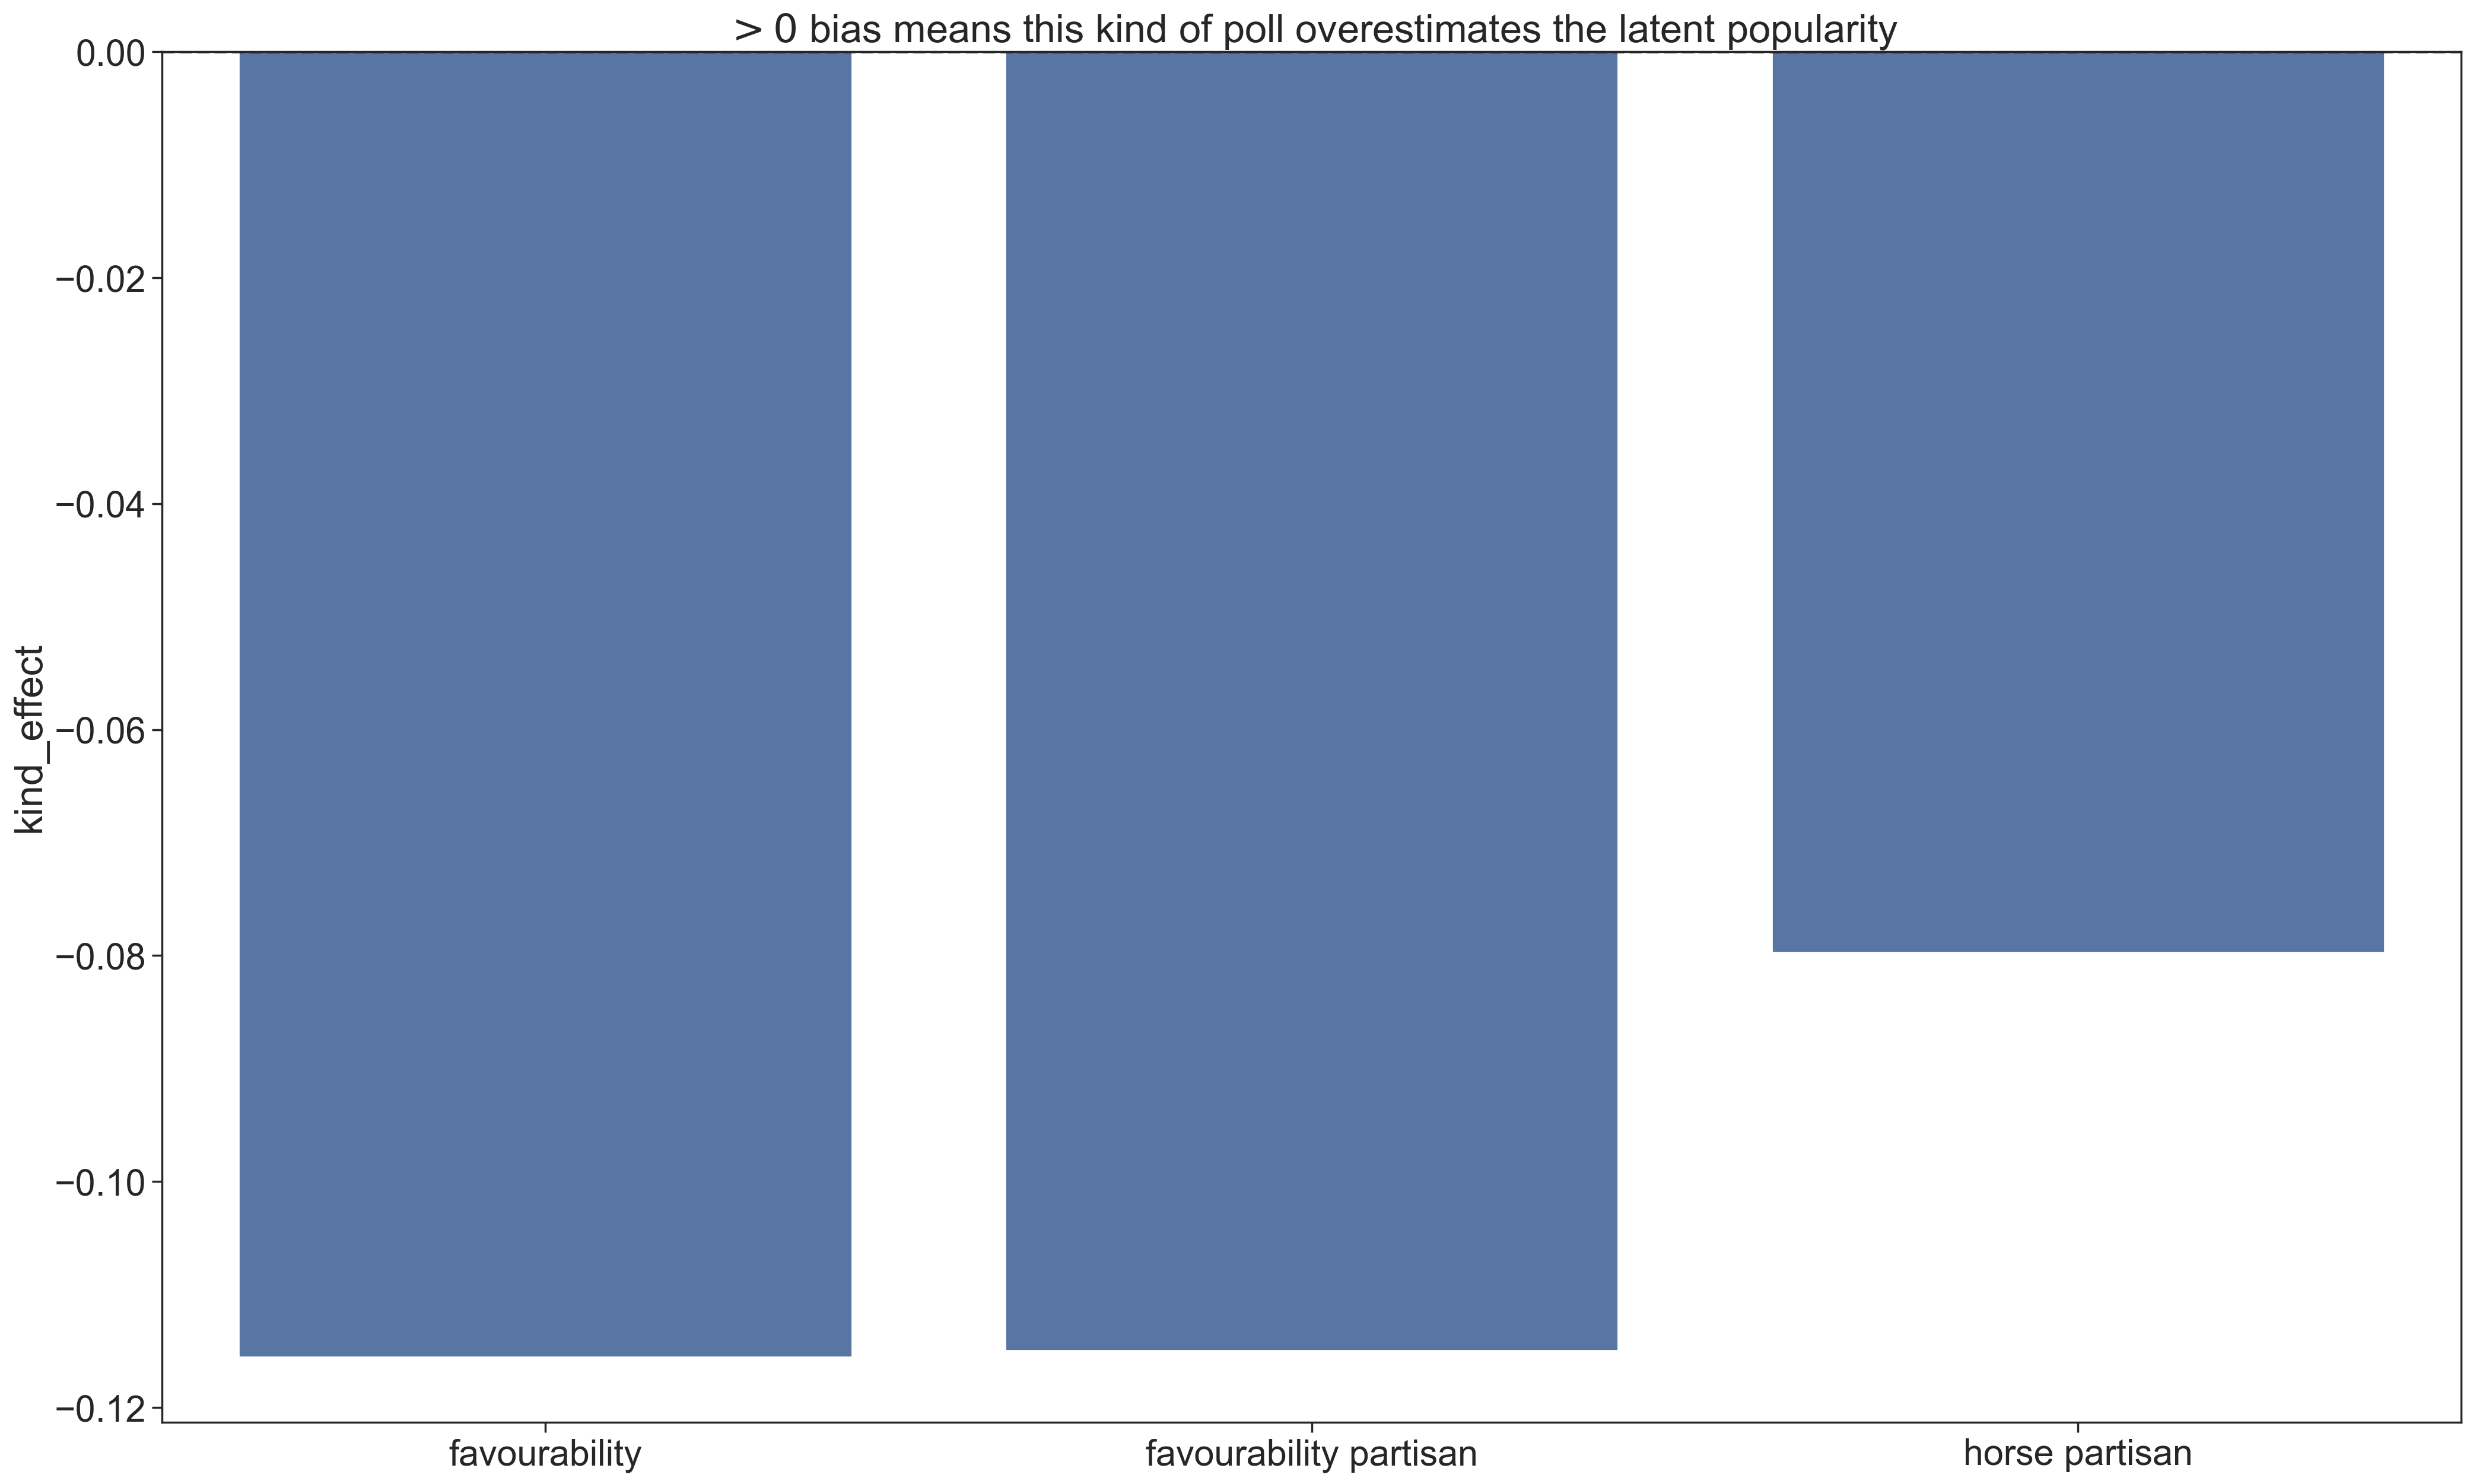

In [235]:
mean_kind_effect = (idata.posterior["kind_effect"].mean(("chain", "draw")).to_dataframe()).reset_index()
ax = sns.barplot(data=mean_kind_effect, x="kind_by_partisan", y="kind_effect")
ax.axhline(0, color="black", linestyle="--", linewidth=2)
ax.set_title("$>0$ bias means this kind of poll overestimates the latent popularity")
ax.set_xlabel(None)
plt.show()

In [236]:
with model:
    pred_oos = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

In [237]:
cand_preds = {}

for c in idata.posterior.coords["candidate"]:
    post = idata.posterior.sel(candidate=c)
    post_pop = expit(post["kind_effect"] + post["candidate_effect"]).stack(sample=("chain", "draw"))
    cand_preds[str(c.values)] = dict(zip(post["kind_by_partisan"].values, post_pop.values))

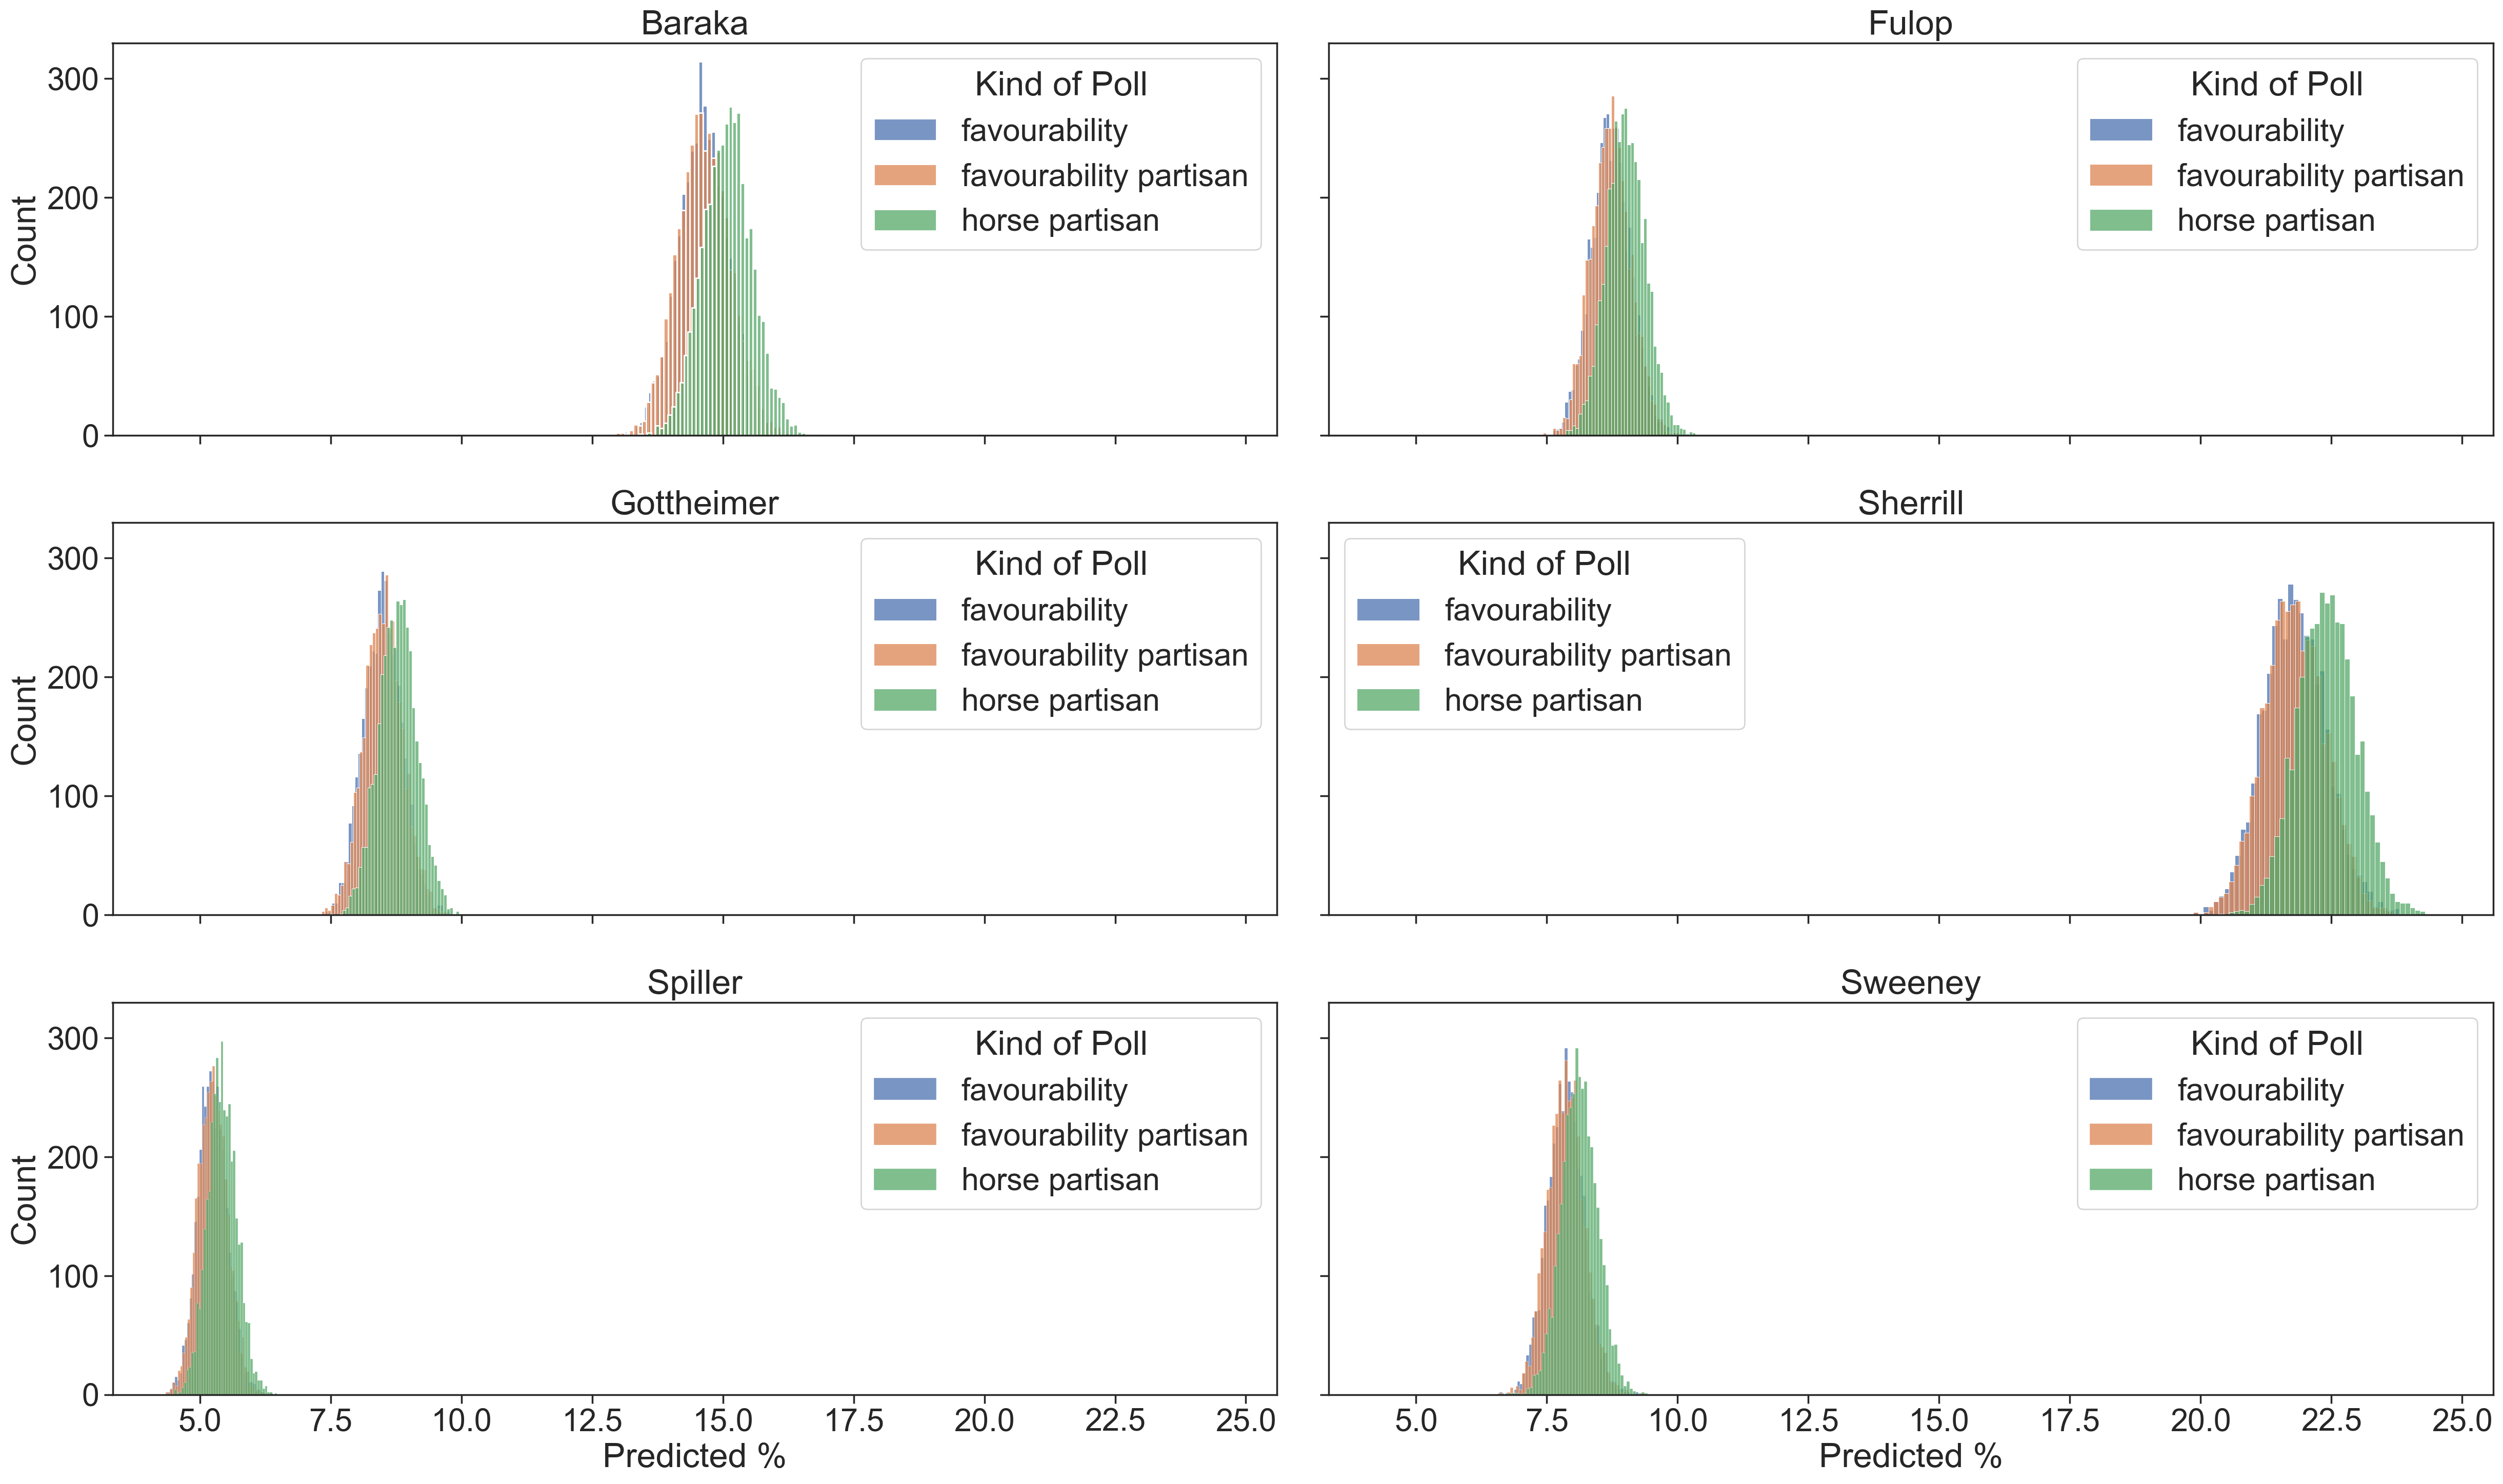

In [238]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True)
for (cand, ax) in zip(cand_preds, axs.ravel()):
    for kind in cand_preds[cand]:
        sns.histplot(x=cand_preds[cand][kind] * 100, label=kind, ax=ax)
    ax.set_title(cand)
    ax.legend(title="Kind of Poll")
    ax.set_xlabel("Predicted %")

plt.tight_layout()